<a href="https://colab.research.google.com/github/omarbenkaddour/uber-lyft-weather-price-prediction/blob/main/UBER_LYFT_vs_Weather_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Introduction




For this project, we analyzed the factors influencing ride prices for Uber and Lyft in Boston during November 2018. Understanding these drivers can help optimize costs, support business strategy, and inform regulatory decisions. We used two Kaggle datasets compiled by Ravimunde ( [link ](https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices/data)): one with over 600,000 ride records (including price, distance, ride type, and location) and another with weather data from the same period.

We merged the datasets by location and time to explore how external factors (e.g., weather, time of day) and internal factors (e.g., ride type, distance) affect pricing. Through exploratory data analysis and visualizations—scatter plots, box plots, and line graphs—we found that vehicle type and ride distance are strongly associated with price increases.

The full analysis and key takeaways are detailed in the notebook. We welcome any feedback or questions.

# Part 2: Data Loading and Processing



In [3]:
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from google.colab import drive
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import gdown


## Part 2.1: Data Loading and Processing for Uber/Lyft


In [13]:
file_id = "10H4cQqfh7KcSjuaI0w5Gea5uYNVDxewl"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "cab_rides.csv", quiet=False)
ride_df = pd.read_csv('cab_rides.csv')

Downloading...
From: https://drive.google.com/uc?id=10H4cQqfh7KcSjuaI0w5Gea5uYNVDxewl
To: /content/cab_rides.csv
100%|██████████| 88.8M/88.8M [00:01<00:00, 53.0MB/s]


In [14]:
ride_df.head(10)

distance cab_type     time_stamp              destination  \
0      0.44     Lyft  1544952607890            North Station   
1      0.44     Lyft  1543284023677            North Station   
2      0.44     Lyft  1543366822198            North Station   
3      0.44     Lyft  1543553582749            North Station   
4      0.44     Lyft  1543463360223            North Station   
5      0.44     Lyft  1545071112138            North Station   
6      1.08     Lyft  1543208580200  Northeastern University   
7      1.08     Lyft  1543780384677  Northeastern University   
8      1.08     Lyft  1543818482645  Northeastern University   
9      1.08     Lyft  1543315522249  Northeastern University   

             source  price  surge_multiplier  \
0  Haymarket Square    5.0               1.0   
1  Haymarket Square   11.0               1.0   
2  Haymarket Square    7.0               1.0   
3  Haymarket Square   26.0               1.0   
4  Haymarket Square    9.0               1.0   
5  Haymarket Square   16.5               1.0   
6          Back Bay   10.5               1.0   
7          Back Bay   16.5               1.0   
8          Back Bay    3.0               1.0   
9          Back Bay   27.5               1.0   

                                     id    product_id          name  
0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line        Shared  
1  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier           Lux  
2  981a3613-77af-4620-a42a-0c0866077d1e          lyft          Lyft  
3  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv  Lux Black XL  
4  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus       Lyft XL  
5  f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2      lyft_lux     Lux Black  
6  462816a3-820d-408b-8549-0b39e82f65ac     lyft_plus       Lyft XL  
7  474d6376-bc59-4ec9-bf57-4e6d6faeb165      lyft_lux     Lux Black  
8  4f9fee41-fde3-4767-bbf1-a00e108701fb     lyft_line        Shared  
9  8612d909-98b8-4454-a093-30bd48de0cb3   lyft_luxsuv  Lux Black XL

The time_stamp variable is encoded in Epoch time (in milliseconds), which we convert to a readable date-time format. We observe 693k unique IDs, likely corresponding to individual cabs or drivers. Since this variable doesn’t meaningfully contribute to price prediction, we drop it from the dataset. Naturally, we also drop null values.



In [15]:
ride_df['time'] = pd.to_datetime(ride_df['time_stamp'], unit='ms').dt.floor('T')
ride_df.drop(columns=['time_stamp'], inplace=True)
ride_df.drop(columns=['id'], inplace=True)
ride_df.head()
ride_df = ride_df.dropna().reset_index(drop=True)
ride_df.describe()

<ipython-input-15-7d7917092487>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ride_df['time'] = pd.to_datetime(ride_df['time_stamp'], unit='ms').dt.floor('T')


distance          price  surge_multiplier  \
count  637976.000000  637976.000000     637976.000000   
mean        2.189261      16.545125          1.015068   
min         0.020000       2.500000          1.000000   
25%         1.270000       9.000000          1.000000   
50%         2.160000      13.500000          1.000000   
75%         2.930000      22.500000          1.000000   
max         7.860000      97.500000          3.000000   
std         1.135413       9.324359          0.095422   

                                time  
count                         637976  
mean   2018-12-05 21:33:49.070748672  
min              2018-11-26 03:40:00  
25%              2018-11-28 22:26:00  
50%              2018-12-02 07:52:00  
75%              2018-12-14 22:45:00  
max              2018-12-18 19:15:00  
std                              NaN

We observe that distances are relatively small, with a standard deviation of just 1.14. This makes sense given the dataset’s focus on a limited number of locations within Boston. The median price is 13.50 and the maximum price is 97.50, with is consistent with typical ride-hailing experiences.

The surge multiplier shows minimal variation (standard deviation of 0.01), although its maximum value is 3.0, which warrants further investigation.

The data spans approximately three weeks, covering late November to mid-December 2018. To identify pricing outliers, we will apply an interquartile range (IQR) test.

In [16]:
numerical_cols = ride_df.select_dtypes(include=['number']).columns

Q1 = ride_df[numerical_cols].quantile(0.25)
Q3 = ride_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = (ride_df[numerical_cols] < (Q1 - 1.5 * IQR)) | (ride_df[numerical_cols] > (Q3 + 1.5 * IQR))
print(outliers.sum())

distance             6672
price                5589
surge_multiplier    20975
dtype: int64


Here, notice that distance and price have some number of outliers according to this test. However, because we find the max and min values of both distance and price to be reasonable, we will be keeping these columns. We will, however, look into surge_multiplier further by creating a histogram. Notice that the number of outliers identified for the surge_multiplier is an order of magnitude greater than the other two.

In [17]:
bins = [0, 1, 2, 3]
ride_df['surge_multiplier_binned'] = pd.cut(ride_df['surge_multiplier'], bins=bins, right=False, labels=["1", "2", "3"])

In [18]:
bins = [1, 2, 3, 4]
labels = ["1", "2", "3"]

ride_df['surge_multiplier_binned'] = pd.cut(ride_df['surge_multiplier'], bins=bins, right=False, labels=labels)

value_counts = ride_df['surge_multiplier_binned'].value_counts().reset_index()

value_counts.columns = ['Range', 'Count']

fig = px.bar(value_counts,
             x='Range',
             y='Count',
             title='Distribution of Surge Multiplier in Ranges',
             labels={'Range': 'Range', 'Count': 'Count'},
             category_orders={'Range': ['1', '2', '3']}
             )

fig.show()

We see that surge_multiplier is greatly unbalanced. There are 635.571k rows with a surge of 1.0, compared to 2393 in range 2, and just 12 rows with range 3. We decide that there isn't enough variation to make meaningful conclusions on surge_variation. Thus, we will be dropping this column.

In [19]:
ride_df.drop(columns=['surge_multiplier', 'surge_multiplier_binned'], inplace=True)
ride_df.head()

distance cab_type    destination            source  price    product_id  \
0      0.44     Lyft  North Station  Haymarket Square    5.0     lyft_line   
1      0.44     Lyft  North Station  Haymarket Square   11.0  lyft_premier   
2      0.44     Lyft  North Station  Haymarket Square    7.0          lyft   
3      0.44     Lyft  North Station  Haymarket Square   26.0   lyft_luxsuv   
4      0.44     Lyft  North Station  Haymarket Square    9.0     lyft_plus   

           name                time  
0        Shared 2018-12-16 09:30:00  
1           Lux 2018-11-27 02:00:00  
2          Lyft 2018-11-28 01:00:00  
3  Lux Black XL 2018-11-30 04:53:00  
4       Lyft XL 2018-11-29 03:49:00

## Part 2.2: Data Loading and Processing for Weather


For the same reasons outlined above in 2.1, we will be using Google Drive to access weather.csv

In [21]:
file_id = "1O_T1a1MXR_nWZGgnDDPwGAVfWU6DPfOp"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "weather.csv", quiet=False)
weather_df = pd.read_csv('weather.csv')

Downloading...
From: https://drive.google.com/uc?id=1O_T1a1MXR_nWZGgnDDPwGAVfWU6DPfOp
To: /content/weather.csv
100%|██████████| 350k/350k [00:00<00:00, 5.39MB/s]


In [22]:
weather_df.head(10)

temp                 location  clouds  pressure    rain  time_stamp  \
0  42.42                 Back Bay     1.0   1012.14  0.1228  1545003901   
1  42.43              Beacon Hill     1.0   1012.15  0.1846  1545003901   
2  42.50        Boston University     1.0   1012.15  0.1089  1545003901   
3  42.11                   Fenway     1.0   1012.13  0.0969  1545003901   
4  43.13       Financial District     1.0   1012.14  0.1786  1545003901   
5  42.34         Haymarket Square     1.0   1012.15  0.2068  1545003901   
6  42.36                North End     1.0   1012.15  0.2088  1545003901   
7  42.21            North Station     1.0   1012.16  0.2069  1545003901   
8  42.07  Northeastern University     1.0   1012.12  0.1020  1545003901   
9  43.05            South Station     1.0   1012.12  0.1547  1545003901   

   humidity   wind  
0      0.77  11.25  
1      0.76  11.32  
2      0.76  11.07  
3      0.77  11.09  
4      0.75  11.49  
5      0.77  11.49  
6      0.77  11.46  
7      0.77  11.37  
8      0.78  11.28  
9      0.75  11.58

The time_stamp column is again in Epoch format, but this time in seconds. We convert it to a standard datetime format for interpretability and then drop the original column. Drop null.


In [23]:
weather_df['time'] = pd.to_datetime(weather_df['time_stamp'], unit='s').dt.floor('T')
weather_df.drop(columns=['time_stamp'], inplace=True)
weather_df.head()
weather_df['rain'] = weather_df['rain'].fillna(0.0)


<ipython-input-23-c7cbb3b08dc1>:1: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



temp            location  clouds  pressure    rain  humidity   wind  \
0  42.42            Back Bay     1.0   1012.14  0.1228      0.77  11.25   
1  42.43         Beacon Hill     1.0   1012.15  0.1846      0.76  11.32   
2  42.50   Boston University     1.0   1012.15  0.1089      0.76  11.07   
3  42.11              Fenway     1.0   1012.13  0.0969      0.77  11.09   
4  43.13  Financial District     1.0   1012.14  0.1786      0.75  11.49   

                 time  
0 2018-12-16 23:45:00  
1 2018-12-16 23:45:00  
2 2018-12-16 23:45:00  
3 2018-12-16 23:45:00  
4 2018-12-16 23:45:00

In [24]:
weather_df.describe()

temp       clouds     pressure         rain     humidity  \
count  6276.000000  6276.000000  6276.000000  6276.000000  6276.000000   
mean     39.090475     0.677777  1008.445209     0.008212     0.763985   
min      19.620000     0.000000   988.250000     0.000000     0.450000   
25%      36.077500     0.440000   997.747500     0.000000     0.670000   
50%      40.130000     0.780000  1007.660000     0.000000     0.760000   
75%      42.832500     0.970000  1018.480000     0.000000     0.890000   
max      55.410000     1.000000  1035.120000     0.780700     0.990000   
std       6.022055     0.314284    12.870775     0.043021     0.127340   

              wind                           time  
count  6276.000000                           6276  
mean      6.802812  2018-12-03 17:15:53.116634880  
min       0.290000            2018-11-26 03:40:00  
25%       3.517500            2018-11-28 06:34:00  
50%       6.570000            2018-11-29 17:52:00  
75%       9.920000            2018-12-13 08:45:00  
max      18.180000            2018-12-18 18:45:00  
std       3.633466                            NaN

The change in temperature over time is modest, which is expected given the three-week data collection period. The weather dataset's date range aligns well with the ridesharing data. Other variables—atmospheric pressure (mb), wind speed (mph), rainfall (in/hr), humidity (%), and cloudiness (0–1)—appear reasonable. No extreme values stand out as outliers, so we retain the full dataset.

## Part 2.3: Joining Dataframes

We observe two entities: ride and weather. Ride includes attributes such as distance, id, product id, source, destination, surge multiplier, name, price, epoch time, and car type. Weather includes humidity, wind, clouds, epoch time, temperature, rain, location, and pressure. In both, epoch time can be converted into a computed date attribute, which further decomposes into year, month, day, hour, minute, and second.

The relationship between the entities is represented by "called": each ride is called under one weather condition, while a weather condition can correspond to many rides. Both datasets share two comparable attributes—epoch time and location (source for ride, location for weather). We choose to join on source and location, given the minimal variation in weather across nearby areas. We use an inner join to retain only rows with matching entries in both tables, as unmatched rows do not contribute to our analysis of factors influencing ride prices.

In [25]:
weather_df = weather_df.rename(columns={'location': 'source'})

df = pd.merge(ride_df, weather_df, on=['time', 'source'], how='inner')

df['time'] = df['time'].dt.strftime('%H:%M:%S')

df.head()



distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name                time  \
0                              lyft_lux     Lux Black 2018-12-02 19:53:00   
1                           lyft_luxsuv  Lux Black XL 2018-11-27 10:45:00   
2                          lyft_premier           Lux 2018-11-26 07:46:00   
3                          lyft_premier           Lux 2018-12-14 19:45:00   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool 2018-12-15 06:45:00   

    temp  clouds  pressure    rain  humidity  wind  
0  50.49    1.00   1004.05  0.0000      0.92  2.46  
1  44.95    0.99    990.87  0.0087      0.97  6.14  
2  41.20    0.94   1014.19  0.0000      0.93  1.95  
3  42.70    0.34   1029.36  0.0000      0.65  4.18  
4  45.14    1.00   1022.35  0.0000      0.91  6.26

Since the data spans less than a month, we do not expect meaningful price variation by date. We therefore extract only the time component and discard the date.


In [26]:
df['time'] = df['time'].dt.strftime('%H:%M:%S')
df.head()

distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name      time   temp  \
0                              lyft_lux     Lux Black  19:53:00  50.49   
1                           lyft_luxsuv  Lux Black XL  10:45:00  44.95   
2                          lyft_premier           Lux  07:46:00  41.20   
3                          lyft_premier           Lux  19:45:00  42.70   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool  06:45:00  45.14   

   clouds  pressure    rain  humidity  wind  
0    1.00   1004.05  0.0000      0.92  2.46  
1    0.99    990.87  0.0087      0.97  6.14  
2    0.94   1014.19  0.0000      0.93  1.95  
3    0.34   1029.36  0.0000      0.65  4.18  
4    1.00   1022.35  0.0000      0.91  6.26

Finally, we will use regex to match on the first two digits of the time.

In [27]:
df['hour'] = df['time'].str.extract(r'(\d{2}):', expand=False).astype(int)
df.drop(columns=['time'], inplace=True)
df.head()

distance cab_type              destination         source  price  \
0      1.08     Lyft  Northeastern University       Back Bay   16.5   
1      1.08     Lyft  Northeastern University       Back Bay   27.5   
2      0.72     Lyft         Haymarket Square  North Station   13.5   
3      3.24     Lyft  Northeastern University  North Station   19.5   
4      2.94     Uber                   Fenway  North Station    9.0   

                             product_id          name   temp  clouds  \
0                              lyft_lux     Lux Black  50.49    1.00   
1                           lyft_luxsuv  Lux Black XL  44.95    0.99   
2                          lyft_premier           Lux  41.20    0.94   
3                          lyft_premier           Lux  42.70    0.34   
4  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool  45.14    1.00   

   pressure    rain  humidity  wind  hour  
0   1004.05  0.0000      0.92  2.46    19  
1    990.87  0.0087      0.97  6.14    10  
2   1014.19  0.0000      0.93  1.95     7  
3   1029.36  0.0000      0.65  4.18    19  
4   1022.35  0.0000      0.91  6.26     6

# Part 3: Exploratory Data Analysis

After cleaning the data, we explored relationships between key feature pairs. We chose these based on their statistical relevance and how important they seemed for shaping our model.

## Part 3.1: Percentage of Lyft and Uber Rides

In [28]:
total_rides = df.shape[0]

uber_rides = df[df['cab_type'] == 'Uber'].shape[0]
lyft_rides = df[df['cab_type'] == 'Lyft'].shape[0]

uber_percentage = (uber_rides / total_rides) * 100
lyft_percentage = (lyft_rides / total_rides) * 100

print(f"Percentage of Uber rides: {uber_percentage:.2f}%")
print(f"Percentage of Lyft rides: {lyft_percentage:.2f}%")

Percentage of Uber rides: 51.86%
Percentage of Lyft rides: 48.14%


The percentage of Uber vs. Lyft rides are very similar, and thus it is possible to conclude that we have enough and balanced data on both companies to analyze going further.

## Part 3.2: Prices over Time

In [29]:
df_grouped = df.groupby(['hour', 'cab_type']).agg({
    'price': 'mean'
}).reset_index()

In [30]:
fig = px.line(df_grouped,
              x='hour',
              y='price',
              color='cab_type',
              title='Average Ride Price for Uber and Lyft Over Time',
              labels={'hour': 'Hour of Day', 'price': 'Average Ride Price'},
              markers=True)

fig.show()

We note two main takeaways:

Lyft prices are consistently higher than Uber prices throughout the day. This may reflect different pricing strategies. Additionally, the two services show distinct trends—for instance, Uber prices tend to drop in the evening, while Lyft prices rise.

There is a clear peak in average prices between 5 PM and 8 PM, suggesting a rush hour effect for both services.

Together, these points suggest that time of day influences pricing, but in different ways for Uber and Lyft.

## Part 3.3: Locations of Rides

We also decided to examine rides by location to gain a better understanding of whether there was geographical concentration of ride locations in Boston. If there was, then that suggests the external validity of our model beyond this subset of locations is likely to be low, as we will primarily be working with data that is concentrated over a small area and thus reflective mostly of that partiular concentration. It also provides a more intuitave way to understand distances as recorded by the dataset. After fethcing the general coordinates of every unique location mentioned in the combined dataset, we decided to use Folium to visualize the ride locations in Boston.


In [56]:
locations = {
    'Financial District': (42.3573, -71.0598),
    'Northeastern University': (42.3370, -71.0892),
    'North Station': (42.3656, -71.0620),
    'Boston University': (42.3505, -71.1054),
    'Back Bay': (42.3601, -71.0657),
    'North End': (42.3646, -71.0542),
    'Haymarket Square': (42.3635, -71.0603),
    'Fenway': (42.3419, -71.0951),
    'West End': (42.3641, -71.0694),
    'South Station': (42.3525, -71.0552),
    'Beacon Hill': (42.3600, -71.0700),
    'Theatre District': (42.3523, -71.0620)
}

location_df = pd.DataFrame(locations.items(), columns=['location', 'coords'])
location_df[['latitude', 'longitude']] = pd.DataFrame(location_df['coords'].to_list(), index=location_df.index)

f = folium.Figure(width=1000, height=1000)

m = folium.Map(width=1000, height=1000, location=[42.3601, -71.0589], zoom_start=13, min_zoom=10, max_zoom=16)

location_df.apply(lambda row: folium.Marker(
    location=[row["latitude"], row["longitude"]],
    popup=folium.Popup(row["location"], max_width=200),
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m), axis=1)

m.add_to(f)

display(f)


* Most locations are clustered in central Boston and are close to one another. This suggests that, in addition to being localized, our model is likely better suited for predicting short-distance trips, which dominate the dataset.

* Three locations lie farther from the cluster, all toward Southwest Boston. This reinforces the idea that most rides occur within the same radius.





## Part 3.4: Price Distributions of Rides

Beyond building an initial understanding of the dataset, we also examined how ride prices are distributed. Since price is our dependent variable, it's important to understand the general patterns it may follow. Given the data’s underlying heterogeneity, we also explored how price varies with factors like vehicle type, distance, weather, and location. Visualizations such as histograms and box plots help clarify how we might expect our model’s predicted prices to behave.

### Part 3.4.1: Price Distribution Histogram

---



We decided to use a histogram to visualize the underlying distributions of prices, including the mode and the extremeties of our data.

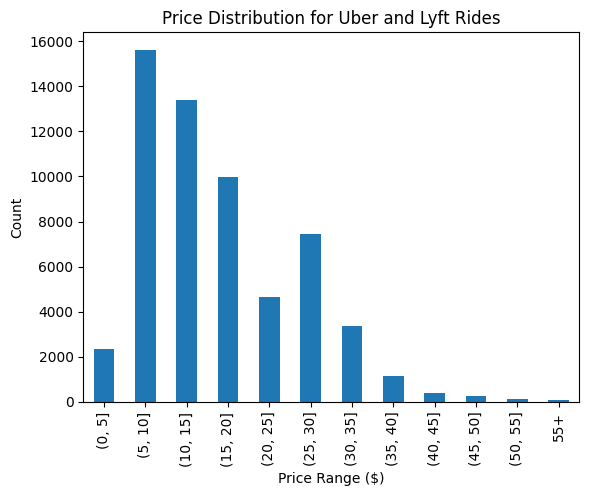

In [39]:
bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 15), (15, 20), (20, 25),
                                     (25, 30), (30, 35), (35, 40), (40, 45), (45, 50),
                                     (50, 55), (55, 200)])

price_counts = pd.cut(df['price'], bins)

price_counts = price_counts.astype(str).replace(r'\(55, 200\]', '55+', regex=True)

price_counts = price_counts.value_counts(sort=False)

ordered_bins = ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]',
                '(25, 30]', '(30, 35]', '(35, 40]', '(40, 45]', '(45, 50]',
                '(50, 55]', '55+']

price_counts = price_counts.reindex(ordered_bins, fill_value=0)

price_counts.plot(kind='bar')

plt.title('Price Distribution for Uber and Lyft Rides')
plt.xlabel('Price Range ($)')
plt.ylabel('Count')

plt.show()

The histogram shows most rides fall between 5 and 20, with a right skew. Rides under 5 are rare, likely due to low profitability. Rides over 40 are also uncommon, likely due to typical pricing patterns and the short-distance nature of trips in this compact area.

### Part 3.4.2: Price Distribution by Vehicle Type

Furthermore, we decide to use a box & whisker plot to visualize the price distributions of each type of vehicle. Notice there are 12 vehicle types in total, 6 belonging to Lyft and 7 belonging to Uber.

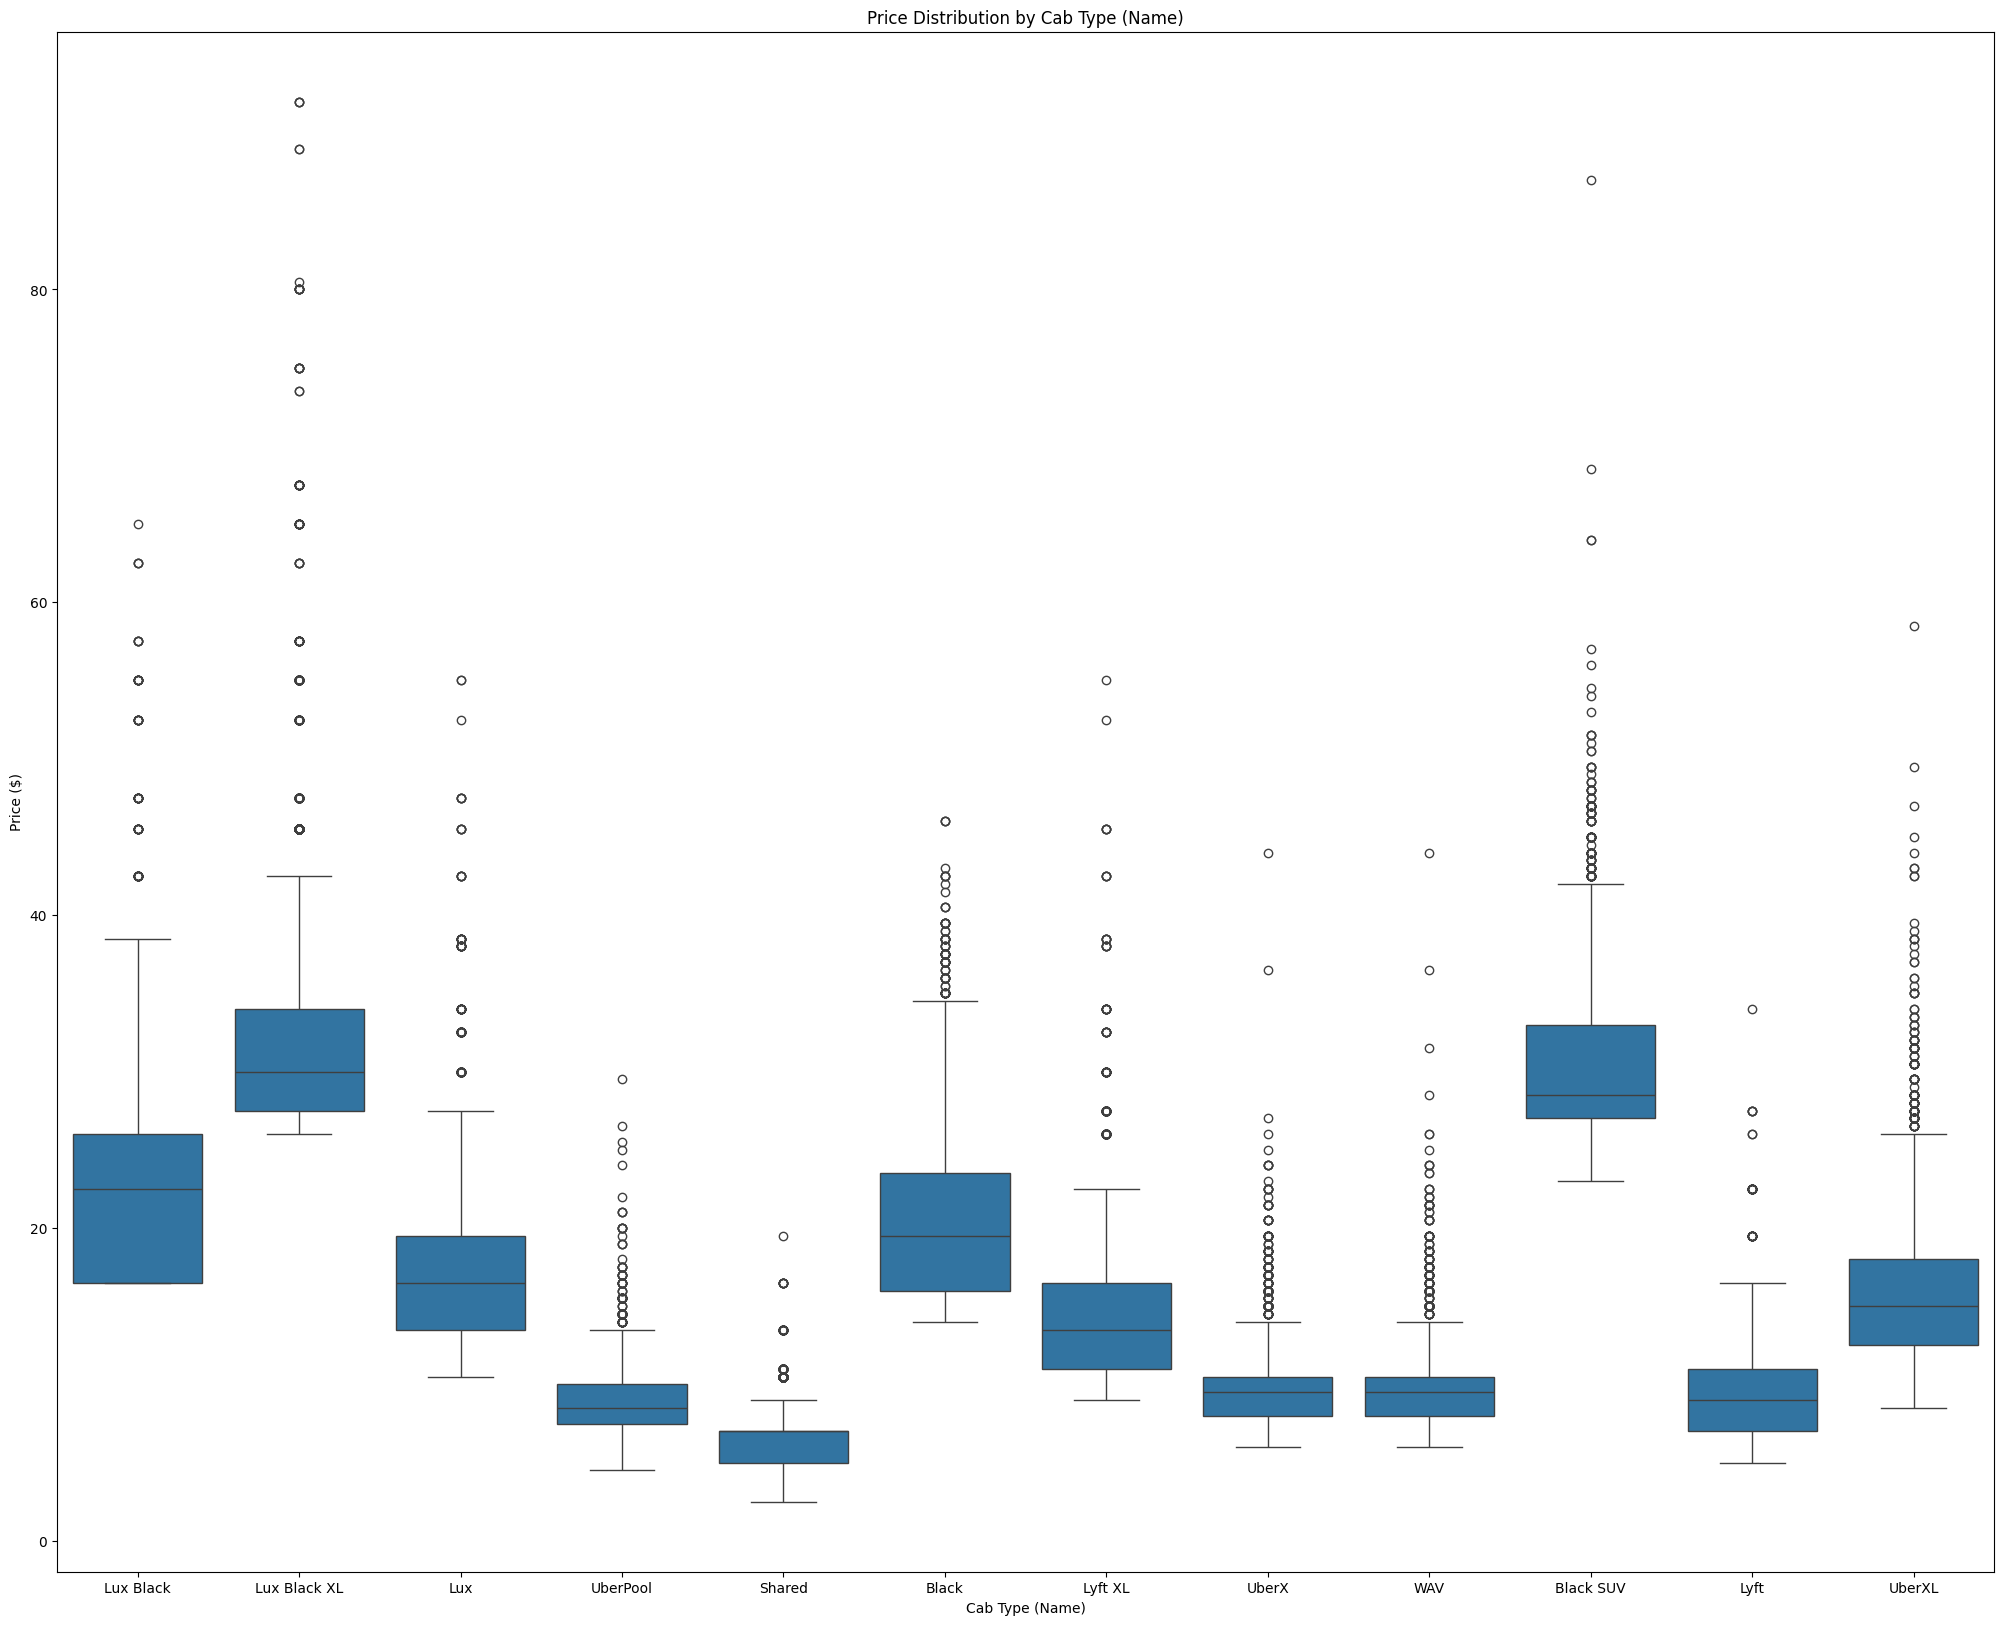

In [40]:
plt.figure(figsize=(25, 20))
sns.boxplot(x='name', y='price', data=df)

plt.title('Price Distribution by Cab Type (Name)')
plt.xlabel('Cab Type (Name)')
plt.ylabel('Price ($)')

plt.show()

We make the following observations from the box plot of price vs. vehicle type:

* Price distributions vary significantly by vehicle type, suggesting it's a key predictor in ride pricing.

* Outliers appear only on the higher end, indicating that rides can cost significantly more, but rarely less.

* Lux Black SUV and Black SUV have the highest median prices, consistent with their luxury positioning.

* Shared and UberPool have the lowest medians, aligning with their budget-oriented ride-sharing purpose.

* Cheaper services show low price variance, while more expensive ones have high variance, likely due to greater sensitivity to factors like distance, demand, or surge pricing.





### Part 3.4.3: Price Distribution over Distances

We explore how price changes with distance for both Uber and Lyft to identify any differences in their pricing behavior. Using a Plotly line graph, we compare how each company's prices respond to changes in distance.

In [42]:
uber_data = df[df['cab_type'] == 'Uber']
lyft_data = df[df['cab_type'] == 'Lyft']

fig_uber = px.scatter(
    uber_data,
    x='distance',
    y='price',
    title="Price vs Distance for Uber",
    labels={'distance': 'Distance (miles)', 'price': 'Price ($)', 'cab_type': 'Cab Type'},
    color_discrete_sequence=["blue"],
)


fig_uber.show()

fig_lyft = px.scatter(
    lyft_data,
    x='distance',
    y='price',
    title="Price vs Distance for Lyft",
    labels={'distance': 'Distance (miles)', 'price': 'Price ($)', 'cab_type': 'Cab Type'},
    color_discrete_sequence=["red"],
)

fig_lyft.show()

Takeaways:

*   There tends to be an increase of prices as distance increases.
*    This observation is more clear with Uber, where it is possible to see how a best fit line would be able to be fitted on the data.
*   Lyft, on the other hand, has a less linear distribution. It seems like Lyft prices demonstrate some stratification, where it is possible to draw horizontal lines of pricing accross distances. These tiers might be connected to different vehicles supplied by Lyft.
*   In conclusion, although distance is an important metric for both companies, it seems that it is more predictive of Uber pricing.





### Part 3.4.5: Price Distribution over Weather

Finally, we decided to look at how weather affects pricing. We will be analyzing the effects of every attribute in the weather dataset to see if any patterns can be identified to inform our analysis moving forward.

In [43]:
weather_features = ['clouds', 'pressure', 'rain', 'humidity', 'wind']

for feature in weather_features:
    fig = px.scatter(df,
                     x=feature,
                     y='price',
                     color='cab_type',
                     title=f"Price vs {feature.capitalize()} for Uber and Lyft",
                     labels={feature: feature.capitalize(), 'price': 'Price ($)', 'cab_type': 'Cab Type'},
                     opacity=0.7)

    fig.update_traces(marker=dict(size=10))

    fig.show()

Overall, there is no clear relationship between weather trends and pricing. The distributions across weather variables appear mostly flat, showing no strong patterns. In the rain plot, most data points correspond to no or light rain, with few instances of heavy rain—a limitation that reduces our ability to analyze its impact. Despite this, the graphs reveal that Lyft and Uber have similar overall pricing, though Lyft shows more high-end outliers. Given weather’s role in our analysis, we found these insights valuable enough to retain the graphs.

## Part 3.5: Feature Correlation HeatMap

We will first be performing a One-Hot Encoding for categorical variables.



Columns after One-Hot Encoding (subset):
Index(['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind', 'hour', 'cab_type_Uber'],
      dtype='object')


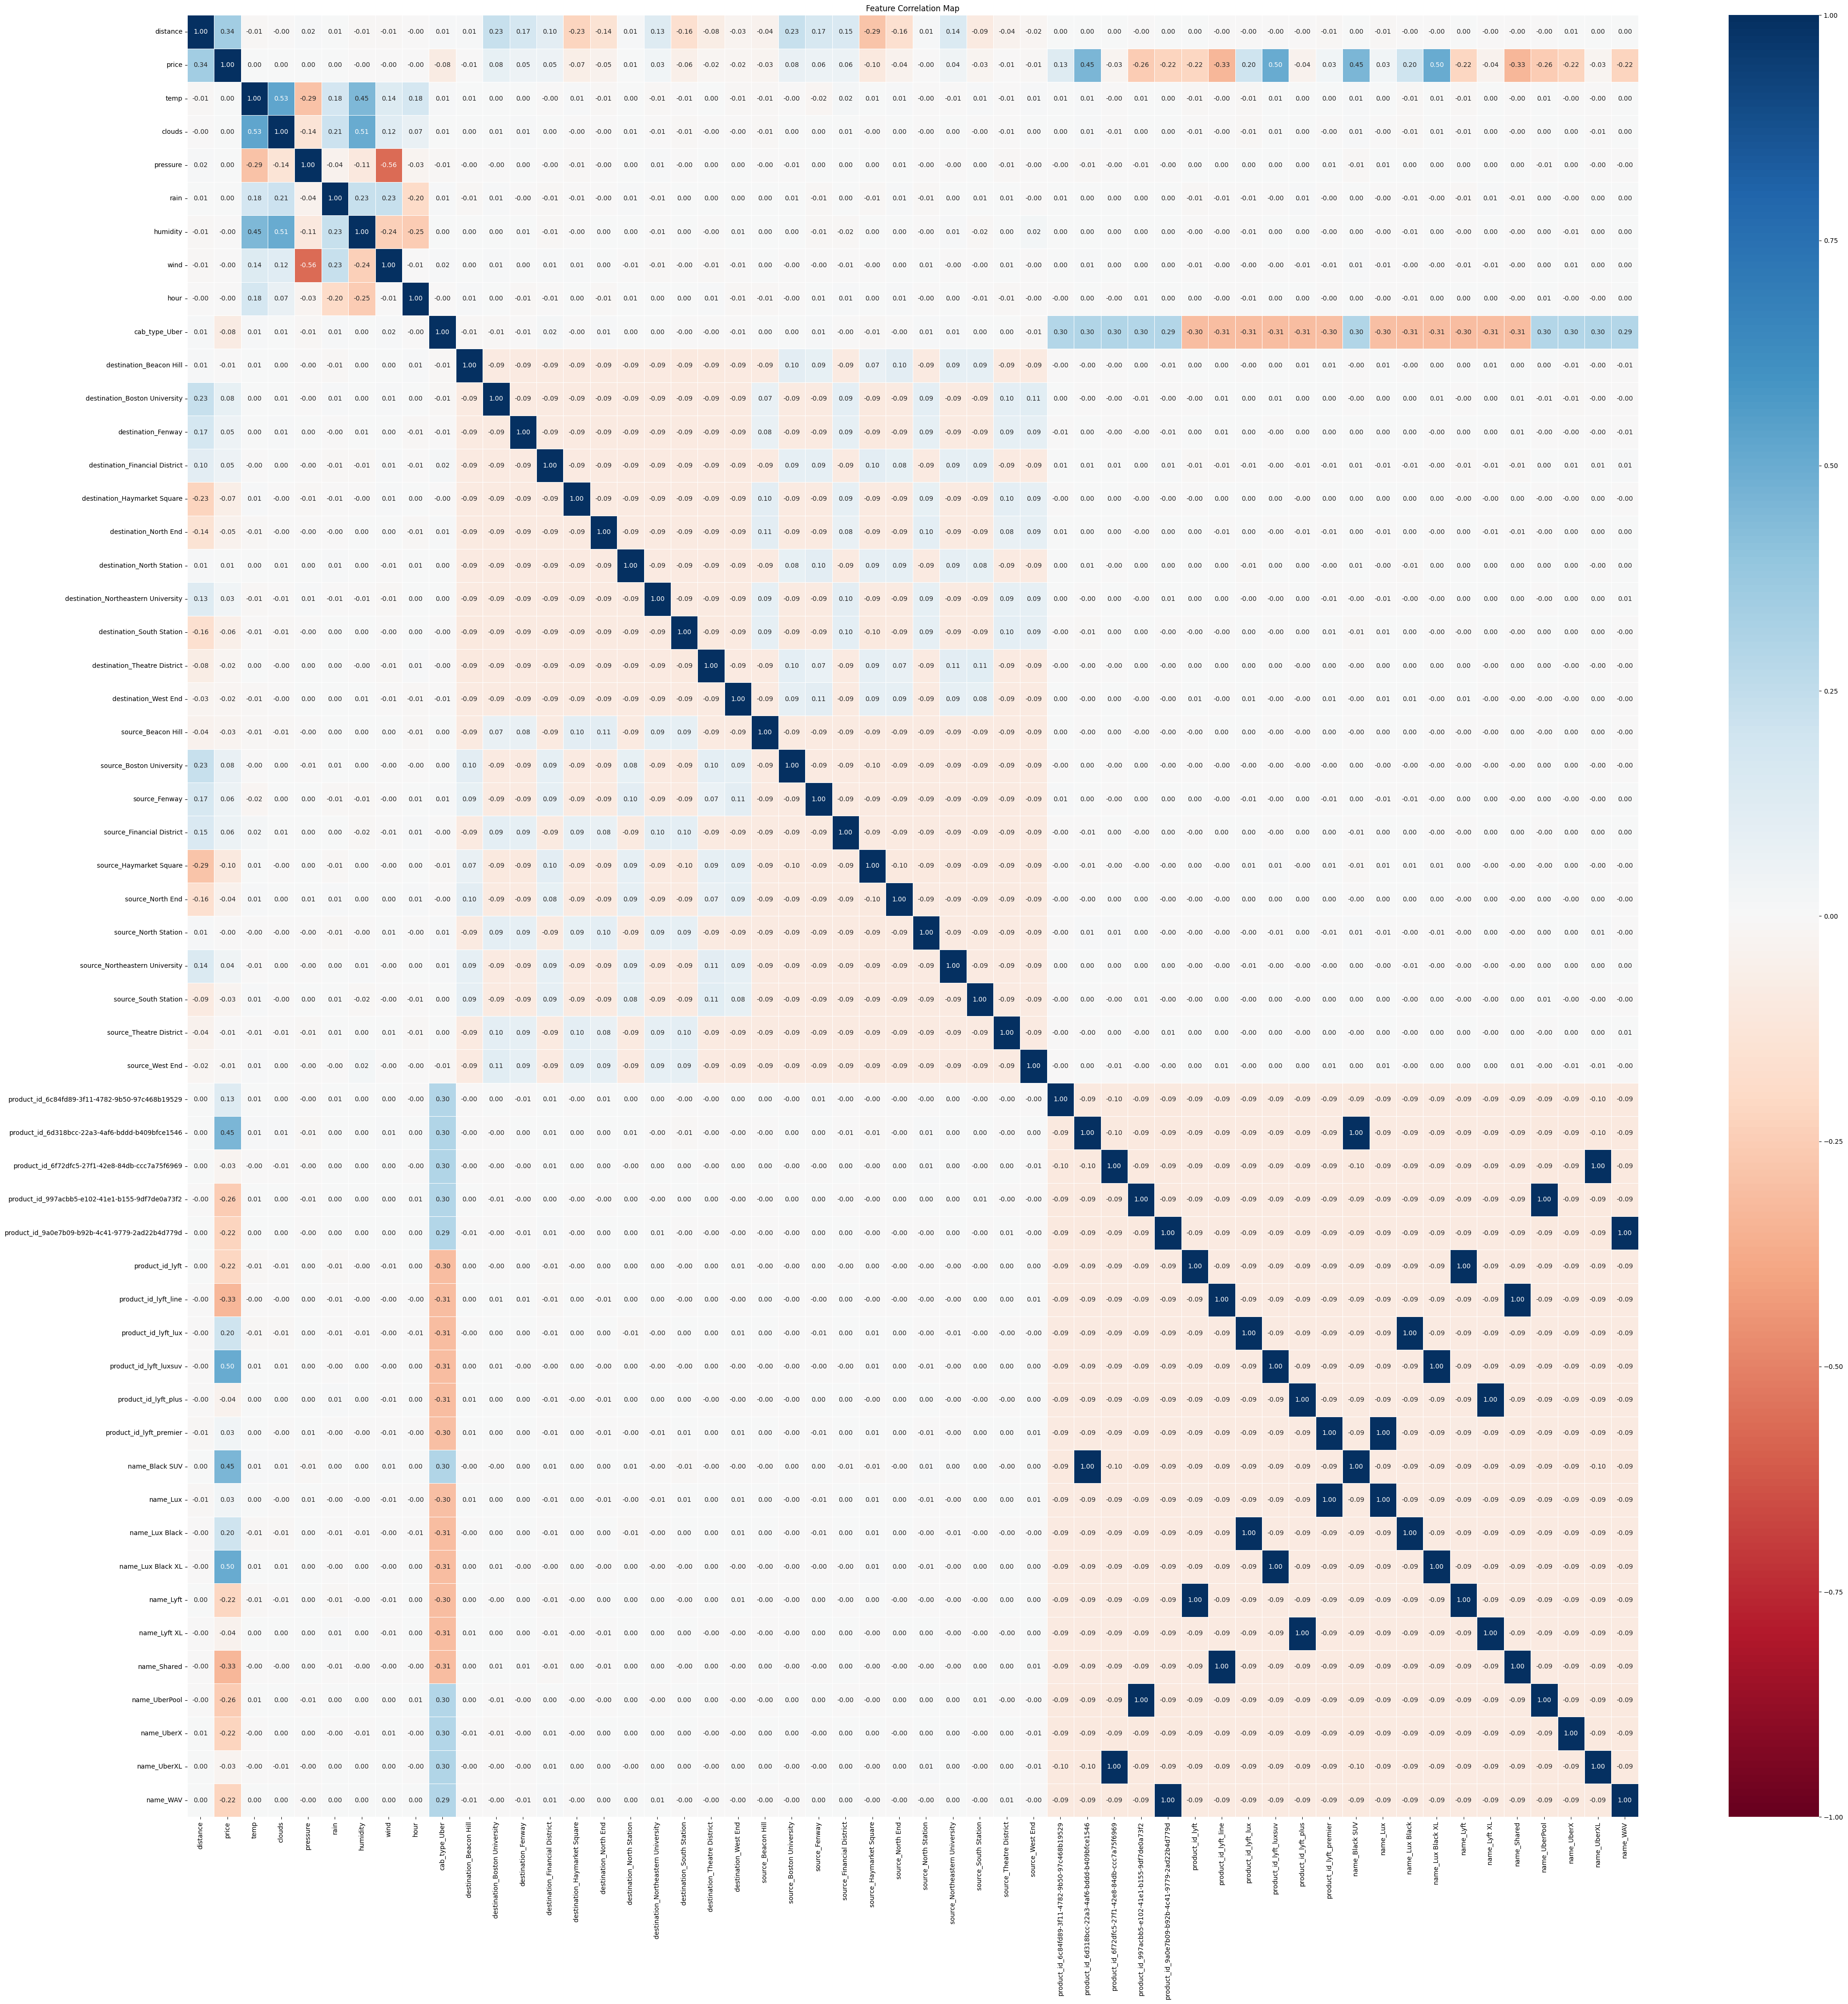

In [44]:
df = pd.get_dummies(df, columns=['cab_type', 'destination', 'source', 'product_id', 'name'], drop_first=True)

print("\nColumns after One-Hot Encoding (subset):")
print(df.columns[:10])

corr_matrix = df.corr()

plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True, fmt=".2f", center=0, linewidths=0.5)

plt.title('Feature Correlation Map')

plt.show()

Notice complete correlation between name and product_id.

In [ ]:
df.drop(columns=['product_id_lyft_premier', 'product_id_lyft_plus', 'product_id_lyft_luxsuv', 'product_id_lyft_lux', 'product_id_lyft_line',
                 'product_id_lyft', 'product_id_9a0e7b09-b92b-4c41-9779-2ad22b4d779d', 'product_id_997acbb5-e102-41e1-b155-9df7de0a73f2',
                 'product_id_6f72dfc5-27f1-42e8-84db-ccc7a75f6969', 'product_id_6d318bcc-22a3-4af6-bddd-b409bfce1546',
                 'product_id_6c84fd89-3f11-4782-9b50-97c468b19529'], inplace=True)

We also know that since names for Uber and Lyft are unique, we don't need to encode whether the cab type is Uber or Lyft.

In [ ]:
df.drop(columns=['cab_type_Uber'], inplace=True)

 # Part 4: Data Preprocessing and Feature Engineering

## Part 4.1: Splitting the Data into Training and Test Sets

The categorical data was already transfromed into numerical data when we performe One Hot Encoding earlier. As such, the next step to prepare the data for modeling is to split it into training and testing. We chose an 80/20 split. This ensures that the models are trained on a large enough sample while retaining unseen data for evaluation. The target variable is the price of the ride, while all other columns serve as features. random_state is 42, as it is the "default" random seed.

In [45]:
from sklearn.model_selection import train_test_split
# Define the features (X) and target variable (y)
X = df.drop(['price'], axis=1)
y = df['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining and Test Data Shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Training and Test Data Shapes:
X_train: (47036, 53), X_test: (11760, 53)
y_train: (47036,), y_test: (11760,)


##Part 4.2: Feature Scaling

Before applying models that rely on distance or gradient-based methods (the ones we are using are Linear Regression and the NN), we scaled the features using StandardScaler. This transforms the data to have a mean of 0 and std of 1. Random Forest is scale-invariant, and therefore we will also be keeping the original unscaled data to use for that model.

In [46]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Training and Test Data:")
print("First 5 rows of Scaled Training Data:\n", X_train_scaled[:5])


Scaled Training and Test Data:
First 5 rows of Scaled Training Data:
 [[-0.58000805  0.41438939  1.058204   -1.10640958 -0.21395666 -0.95043007
   0.47259994  1.30680079 -1.03947221 -0.30198662  3.34070196 -0.3002228
  -0.30395232 -0.29633468 -0.29501677 -0.30001236 -0.29900087 -0.30876836
  -0.30889225 -0.30240556 -0.29624977 -0.30536909 -0.29849426 -0.29862097
  -0.31353591 -0.30436947 -0.30114756 -0.3013155  -0.29599496 -0.30076948
  -0.30361833 -0.30868574 -0.30864442 -0.31017066 -0.30777599 -0.30416094
  -0.29228318 -0.29612238 -0.29929612  3.38963777 -0.2955274  -0.29232602
  -0.30864442 -0.29232602 -0.29929612  3.38963777 -0.29228318 -0.2955274
  -0.29612238 -0.30777599 -0.30752758 -0.31017066 -0.30416094]
 [ 0.59003513  0.35623598  0.21920499  1.53351783 -0.21395666 -0.21794683
  -0.83304585  1.4457723   0.96202668  3.31140502 -0.29933829 -0.3002228
  -0.30395232 -0.29633468 -0.29501677 -0.30001236 -0.29900087 -0.30876836
  -0.30889225 -0.30240556 -0.29624977 -0.30536909 -0.29

##Part 4.3: Principle Component Analysis
To address multicollinearity and reduce the dimensionality of the dataset, we applied PCA, choosing to retain 95% of the variance (which we believe to be good enough a balance between dimensionality reduction and model accuracy)

In [47]:
from sklearn.decomposition import PCA
import numpy as np
# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% variance

# Fit PCA on training data and transform both train and test sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print PCA results
print(f"Number of Principal Components Retained: {pca.n_components_}")
print(f"Explained Variance Ratios (First 5): {pca.explained_variance_ratio_[:5]}")
print(f"Cumulative Explained Variance (First 5): {np.cumsum(pca.explained_variance_ratio_)[:5]}")

Number of Principal Components Retained: 33
Explained Variance Ratios (First 5): [0.05826733 0.04264378 0.04138665 0.04133227 0.04126569]
Cumulative Explained Variance (First 5): [0.05826733 0.10091111 0.14229776 0.18363003 0.22489572]


###Visualizing Explained Variance

This is to show how much of the total variance is captured by each principal component while perfoming PCA, which will help us determine how many principle components should be retained to capture a signitificant portion of the variability

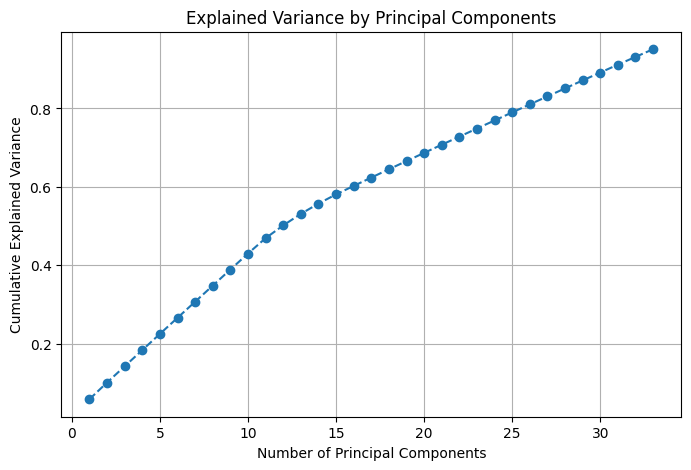

In [48]:
import matplotlib.pyplot as plt
# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

The graph seems to grow linearly, so there should not be a reason to cut off the components early. If it were to grow logarithmically, perhaps we would have chosen to limit the number of components. In the end, we chose to stick with the 33 components.

## Part 5.1: Linear Regression as Baseline Model

Linear Regression serves as a decent baseline model to evaluate how well the features explain ride prices. This model will be trained on the PCA-transformed data

In [51]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model on the PCA-transformed training data
lr.fit(X_train_pca, y_train)

# Predict on the test data
y_pred_lr = lr.predict(X_test_pca)

###Evaluating the Model
We evaluate the model in term of $R^2$ score, which measures the proportion of variance explained by the model, and Root Mean Squared Error, which shows how off the model is.

In [52]:
# Calculate RMSE and R² score
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_score_train = lr.score(X_train_pca, y_train)
lr_score_test = lr.score(X_test_pca, y_test)

# Print the evaluation results
print("\nLinear Regression Performance:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"Training Set R² value: {lr_score_train:.4f}")
print(f"Test Set R² value: {lr_score_test:.4f}")


Linear Regression Performance:
RMSE: 3.37
Training Set R² value: 0.8654
Test Set R² value: 0.8684


The model already seems to do very well on the data (surprisingly high $R^2$ and low RMSE). Therefore, we are very confident that the features explain the price very well and we are optimistic about what the next models can do.

###Checking Assumptions of Linear Regression
Here we want to look into the residuals and see a more in-depth view of how the model performs.

###Residual Analysis

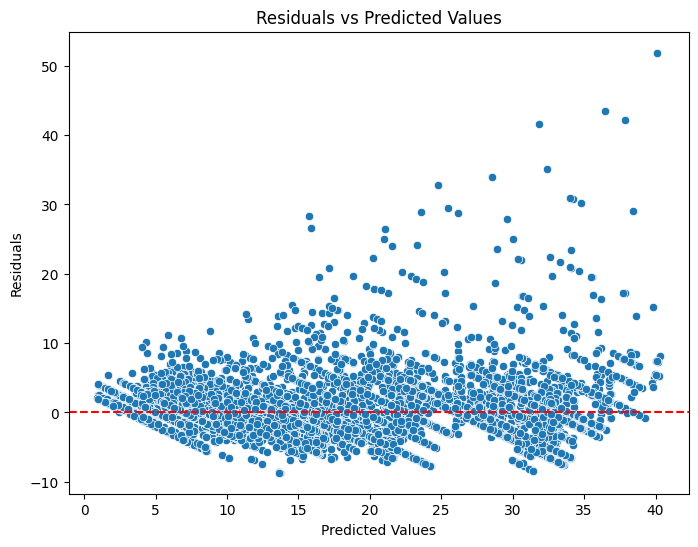

In [53]:
# Calculate residuals
residuals = y_test - y_pred_lr

# Plot residuals vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

The pattern look fairly decent. However, it is fanning out a little bit when with the increase in predicted values. This might mean that the model struggles at certain ranges of data. But, as a baseline model, it is more than satisfactory.

###Normality of Residuals

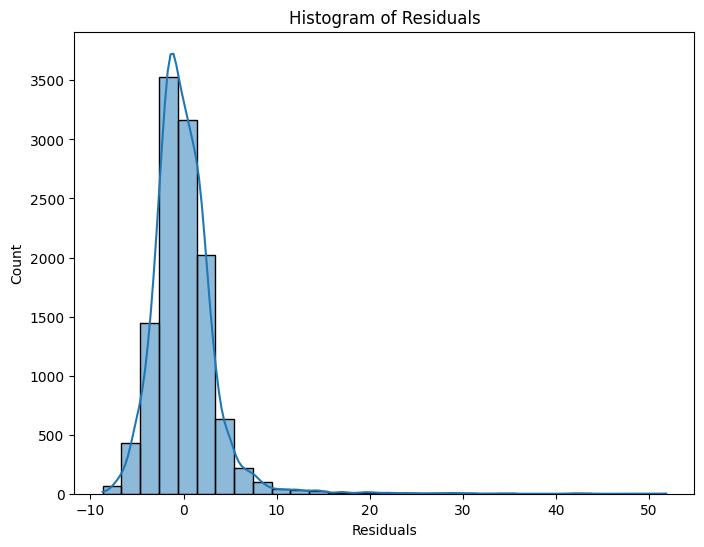

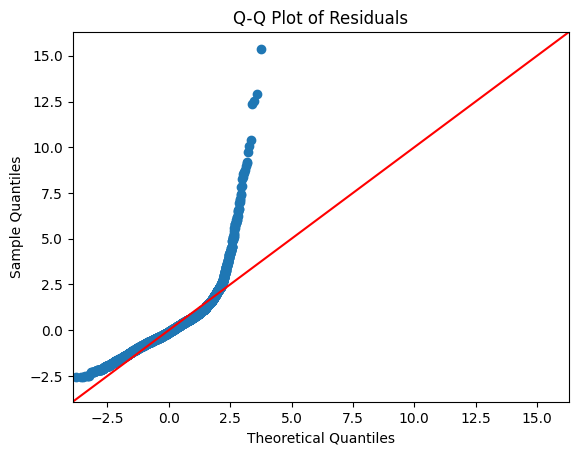

In [54]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

The **Histogram** shows a very good curve around the zero point, meaning that the prediscions are fairly unbiased and the errors are normally distributed for the most part - there seem to be a few outliers which are better described in the next plot.


The **Q-Q** plot shows an upward curve in the higher quantiles, indicating that the residuals are right-skewed. This suggests the model tends to underpredict ride prices for higher values. The deviation highlights that the linear model may not fully capture the complex relationships in the data, particularly for extreme ride prices. To address this, we would want to use non linear models like Random Forest or FCN.

## Part 5.2: Random Forest Regression

Because we wanted to focus on a non-linear model based on insights from our linear regression results, we chose to implement a Random Forest Regression model to predict ride prices. Since Random Forest is scale-invariant, we used the original features rather than the PCA-transformed data.

###Initialize and train

In [55]:
# Initialize the Random Forest object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_regressor.fit(X_train, y_train)
print("\nRandom Forest Model Trained Successfully!")


Random Forest Model Trained Successfully!


###Make the predictions

In [ ]:
# Predict on the training set
y_train_pred_rf = rf_regressor.predict(X_train)

# Predict on the test set
y_test_pred_rf = rf_regressor.predict(X_test)



###Evaluate the Performance of the Models

Same as before, we compute the $R^2$ score and RMSE to see how good the model's predictions are.

In [ ]:
# Calculate R² scores for training and test sets
r2_rf_train = r2_score(y_train, y_train_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)

# Calculate RMSE for the test set
rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# Print model performance metrics
print("\nRandom Forest Model Performance:")
print(f"Training Set R² value: {r2_rf_train:.4f}")
print(f"Test Set R² value: {r2_rf_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")


Random Forest Model Performance:
Training Set R² value: 0.9875
Test Set R² value: 0.9125
Root Mean Squared Error (RMSE): 2.75


The values are great! Again, $R^2$ is incredibly high and RMSE is fairly low. When it comes to the $R^2$ score, the fact that it is so high on the training set might create worries about overfitting. However, it is still performing really well on the test set.

###Hyperparameter Tuning Using RandomizedSearchCV

Because of the very high $R^2$ score for training (which would indicate overfitting), we thought to implement RandomizedSearchCV to see if optimizing the hyperparameters would improve the performance of the model at all. We have exerimented with different param_dist (initial n_estimators \[100, 200, 500\]; max_depth \[6, 9, 12, 15\], min_samples_split \[2, 5, 10\]; min_samples_leaf \[1, 2, 4\]), narrowing the search space around the previously best hyperparameters, and introducing finer granularity in n_estimators and max_depth.

In [ ]:

# Define the parameter grid
param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [12, 15, 18, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,     # Number of random combinations to test
    cv=3,          # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1      # Use all available CPU cores
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Best hyperparameters
best_params = random_search.best_params_
print("\nBest Hyperparameters Found:")
print(best_params)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Hyperparameters Found:
{'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 18}


After finding the best hyperparameters, evaluate the new performance of the model.

In [ ]:
# Train the Random Forest model with best parameters
rf_optimized = RandomForestRegressor(**best_params, random_state=42)

# Fit the model
rf_optimized.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred_optimized = rf_optimized.predict(X_train)
y_test_pred_optimized = rf_optimized.predict(X_test)

# Evaluate the optimized model
r2_train_optimized = r2_score(y_train, y_train_pred_optimized)
r2_test_optimized = r2_score(y_test, y_test_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_test_pred_optimized))

print("\nOptimized Random Forest Model Performance:")
print(f"Training Set R² value: {r2_train_optimized:.4f}")
print(f"Test Set R² value: {r2_test_optimized:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_optimized:.2f}")



Optimized Random Forest Model Performance:
Training Set R² value: 0.9516
Test Set R² value: 0.9199
Root Mean Squared Error (RMSE): 2.63


It seems like tuning the hyperparameters has succesfully made the model a little better. The training $R^2$ is not as high as before, which was our main concern, and the test $R^2$ was improved by a really small margin. The final model is very good overall and its accuracy is more than satisfactory.

###Feature Importance Analysis

Random Forest, as an ensemble method, not only provides strong predictive performance but also offers feature importance scores that help identify which features have the most significant impact on the model's predictions. Even though our main goal was prediction, this analysis enhances the interpretability of the model and provides valuable insights into the relationships between input features and the target variable.


Top 10 Important Features:
              Feature  Importance
30     name_Black SUV    0.264483
33  name_Lux Black XL    0.259476
0            distance    0.153502
32     name_Lux Black    0.094833
36        name_Shared    0.046931
34          name_Lyft    0.039521
38         name_UberX    0.032882
40           name_WAV    0.031742
37      name_UberPool    0.027794
39        name_UberXL    0.007816


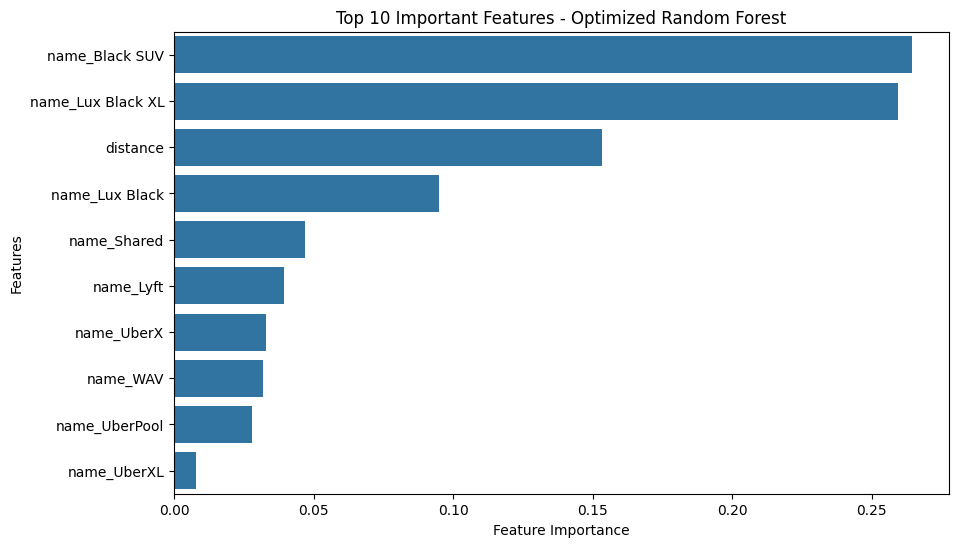

In [ ]:
# Extract feature importance
importances = rf_optimized.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 features

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Important Features - Optimized Random Forest")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


This shows that weather is not as important as the other features when predicting price. This also has to do with the dataset. Because the time frame is not large, there was not enough weather data for it to become relevant, something that was explained earlier. Car/ride type and distance are most important, whereas time and weather are not included in the top list.

## Part 5.3: Fully Connected Neural Network
The final model we wanted to implement is an FCN. The reasoning for this is related to our main goal: prediction of price. Therefore, we choose to sacrifice feature importance and analysis for a more predictive model that would output the best results.

###Model Initialization

Compared to other possible implementations, we decided to use the Keras Sequential API for both simplicity of use and simplicity of understanding.

The Sequential model is initialized as a linear stack of layers, where each layer is added step-by-step. The first layer is a Dense layer with 128 neurons, a ReLU activation function to introduce non-linearity, and an input shape matching the number of features in the training data. A Dropout layer follows, with 20% of the neurons randomly deactivated during training to prevent overfitting. The second hidden layer consists of 64 neurons, also using ReLU activation, followed by another Dropout layer for further regularization. The final output layer has a single neuron with a linear activation function, suitable for regression tasks as it outputs continuous values.

The model is compiled with the Adam optimizer, an adaptive optimization algorithm that efficiently adjusts learning rates for faster convergence. The Mean Squared Error (MSE) loss function is specified to minimize the squared difference between predicted and actual values, a standard choice for regression. Additionally, Mean Absolute Error (MAE) is used as a monitoring metric during training. The model summary provides a detailed overview of the layers, output shapes, and total trainable parameters, which is particularly useful for debugging and understanding the model’s architecture. This implementation in Keras demonstrates how to quickly build, regularize, and compile a neural network for regression tasks with just a few lines of clean and intuitive code.

In [ ]:
# Initialize the FCN model
fcn_model = Sequential()

# Input Layer and First Hidden Layer
fcn_model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
fcn_model.add(Dropout(0.2))  # Dropout for regularization

# Second Hidden Layer
fcn_model.add(Dense(64, activation='relu'))
fcn_model.add(Dropout(0.2))

# Output Layer
fcn_model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
fcn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
fcn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

###Training

This code trains the FCN using the Keras fit() function. It iteratively updates the model's weights over 50 epochs with batches of 32 samples at a time. During training, the model's performance is evaluated on the validation data, allowing us to monitor generalization and overfitting. The training history provides a record of the loss and metrics, enabling further analysis and fine-tuning of the model. This process showcases the power of Keras for training neural networks efficiently with minimal code.

In [ ]:
# Train the FCN model
history = fcn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 50.8476 - mae: 4.3076 - val_loss: 7.6941 - val_mae: 1.6000
Epoch 2/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.1358 - mae: 2.2364 - val_loss: 7.7351 - val_mae: 1.5360
Epoch 3/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.4113 - mae: 2.0762 - val_loss: 7.2790 - val_mae: 1.5045
Epoch 4/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.6631 - mae: 2.0569 - val_loss: 7.0863 - val_mae: 1.5079
Epoch 5/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.4283 - mae: 2.0260 - val_loss: 7.1879 - val_mae: 1.4854
Epoch 6/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0770 - mae: 1.9804 - val_loss: 7.1140 - val_mae: 1.5792
Epoch 7/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7144 - mae: 1.9913 - val_loss: 7.1492 - val_mae: 1.5668
Epoch 8/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0209 - mae: 1.9412 - val_loss: 7.2234 - val_mae: 1.4484
Epoch 9/50
1470/1470 ━━━━━━━━━━━

###Model Evaluation

The metrics for evaluation are the same as before: $R^2$ and RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_train_pred_fcn = fcn_model.predict(X_train_scaled)
y_test_pred_fcn = fcn_model.predict(X_test_scaled)
r2_train_fcn = r2_score(y_train, y_train_pred_fcn)
r2_test_fcn = r2_score(y_test, y_test_pred_fcn)
# Calculate RMSE and R² Score
rmse_fcn = np.sqrt(mean_squared_error(y_test, y_test_pred_fcn))
r2_test_fcn = r2_score(y_test, y_test_pred_fcn)
r2_train_fcn = r2_score(y_train, y_train_pred_fcn)

# Print results
print("\nFully Connected Neural Network Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_fcn:.2f}")
print(f"Train R² Score: {r2_train_fcn:.4f}")
print(f"Test R² Score: {r2_test_fcn:.4f}")

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Fully Connected Neural Network Performance:
Root Mean Squared Error (RMSE): 2.64
Train R² Score: 0.9219
Test R² Score: 0.9190


The results are really good! This model shows less overfitting than the previous model and has a great score for the test set. This has been the best performing model so far and is the most appropriate for our goals (prediction).

When changing the model for a better perforance, we might want to consider the number of neurons and hidden layers when it comes to both overfitting and performance.

###Visualizing Training and Validation Loss

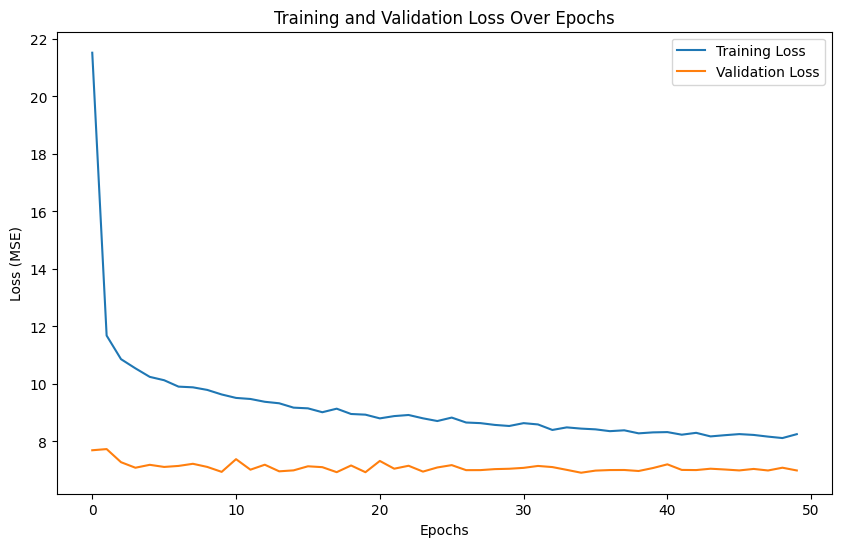

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Given that the Validation loss does not change greatly throughout all epochs, it is unnecessary to use all 50. Therefore, we might want to stop at around 25 epochs in the future, where the training validation seems to plateau as well.

# Conclusion

In this project, we explored the factors influencing Uber and Lyft ride prices in Boston using a dataset combining ride and weather information. Through comprehensive data cleaning, visualization, and modeling, we identified key drivers of price—namely distance and vehicle type—while weather had limited predictive power due to narrow temporal and spatial variation.

We began with exploratory data analysis to understand distributions and trends, followed by feature engineering and dimensionality reduction. For modeling, we compared a linear regression baseline, a Random Forest regressor, and a fully connected neural network. The neural network achieved the best performance and showed the least overfitting, with a test R² of 0.92 and a low RMSE.

While our results are promising, limitations remain—especially the dataset’s short time span and geographic concentration. Future work could expand the time window, integrate traffic data, and explore more granular temporal features to further enhance model robustness and applicability.